In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, chi2
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

XGBoostError: 
XGBoost Library (xgboost.dll) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ['[WinError 193] %1 nie jest prawidłową aplikacją systemu Win32']


In [ ]:
# Path of file to read
data_path = 'CollegeBasketballPlayers2009-2021.csv'
total_ball_data = pd.read_csv(data_path, low_memory = False)
total_ball_data = total_ball_data.drop(['ht', 'yr', 'num', 'pid', 'type', 'Rec Rank', 'gbpm', 'ogbpm', 'dgbpm', 'Unnamed: 64', 'Unnamed: 65'], axis=1)


Zmiana zmiennej objasnianej 'pick' na zmienna binarna i filtracja danych

In [ ]:
#Przerabiam dane - zmienną objasniana pick przerabiam na binarną
total_ball_data["pick"] = total_ball_data["pick"].replace(np.nan, 0)
for i in range(len(total_ball_data)):
    if total_ball_data["pick"][i] >=1:
        total_ball_data["pick"][i]=1

total_ball_data['pick'] = total_ball_data['pick'].astype(int)

#filtruje przez te 3 kolumny zeby nie stracic zbyt duzej liczby zmiennych objasniajacych 
# w ten sposob tracę 9 a nie 34 zmiennych objasniajacych
total_ball_data =total_ball_data[total_ball_data['drtg'].notna()]
total_ball_data =total_ball_data[total_ball_data['ast'].notna()]
total_ball_data =total_ball_data[total_ball_data['dunksmade'].notna()]

total_ball_data['rimmade/(rimmade+rimmiss)'].fillna(0, inplace=True)
total_ball_data['midmade/(midmade+midmiss)'].fillna(0, inplace=True)
total_ball_data['dunksmade/(dunksmade+dunksmiss)'].fillna(0, inplace=True)
total_ball_data['ast/tov'].fillna(0, inplace=True)

total_ball_data = total_ball_data._get_numeric_data()

Na danych do 2020 roku włącznie uczę model. Na danych z 2021 dokonam weryfikacji modelu. 

In [ ]:
ball_data = total_ball_data.loc[total_ball_data['year'] < 2021]
ball_data = ball_data.drop(['year'], axis=1)
ball_data_2021 = total_ball_data.loc[total_ball_data['year'] == 2021]
ball_data_2021 = ball_data_2021.drop(['year'], axis=1)
total_ball_data = total_ball_data.drop(['year'], axis=1)
#ball_data

In [ ]:
def conf_matrix(val_y, pred_test):    
    # Creating a confusion matrix
    con_mat = confusion_matrix(val_y, pred_test)
    con_mat = pd.DataFrame(con_mat, index=['Not Drafted', 'Drafted'], columns=['Not Drafted', 'Drafted'])
    
    # Plotting the confusion matrix
    plt.figure(figsize=(6, 6))
    sn.set(font_scale=1.5)
    sn.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

    # Adding labels and title
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')

In [ ]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
#features = ['Min_per', 'ftr', 'pts', 'ORB_per', 'DRB_per', 'blk_per', 'stl_per', 'dporpag', 'porpag', 'AST_per', 'TO_per', 'FT_per']

X = ball_data.loc[:,ball_data.columns!='pick']

colnames=list(X)
#display(X)
#X = ball_data[features]

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [ ]:
# Define XGBoost model with imbalanced class handling
xgb_model = XGBClassifier(scale_pos_weight=(len(train_y) - sum(train_y)) / sum(train_y))

# Train the model
xgb_model.fit(train_X, train_y)

# Make predictions on validation data
val_preds = xgb_model.predict(val_X)

# Calculate F1 score on validation data
val_f1 = f1_score(val_y, val_preds)

# Print validation F1 score
print("Validation F1 score: {:.2f}".format(val_f1))

# Print confusion matrix on validation data
print("Confusion matrix on validation data:")
print(confusion_matrix(val_y, val_preds))

In [ ]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

# Save predictions in right format
#output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
#output = output.astype({'Pick':'int'})
#output = output.astype({'Actual Pick':'int'})
#output.to_csv('predictions2021.csv', index=False)
#output

In [ ]:
#Setting the range for class weights
weights = np.linspace(0.0,0.99,10)

#Creating a dictionary grid for grid search
param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

#Fitting grid search to the train data with 5 folds
gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=StratifiedKFold(), 
                          n_jobs=-1, 
                          scoring='f1', 
                          verbose=2).fit(train_X, train_y)

#Ploting the score for different values of weight
sn.set_style('whitegrid')
plt.figure(figsize=(12,8))
weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
sn.lineplot(weigh_data['weight'], weigh_data['score'])
plt.xlabel('Weight for class 1')
plt.ylabel('F1 score')
plt.xticks([round(i/10,1) for i in range(0,11,1)])
plt.title('Scoring for different class weights', fontsize=24)
# Get the index of the highest F1 score
best_index = gridsearch.best_index_

# Get the corresponding weight values for weight one and weight two
best_weight_one = 1 - weights[best_index]
best_weight_two = weights[best_index]

# Get the highest F1 score
best_f1_score = gridsearch.cv_results_['mean_test_score'][best_index]

# Print the results
print("Highest F1 Score:", best_f1_score)
print("Weight for Class 1:", best_weight_one)
print("Weight for Class 2:", best_weight_two)

Nowy model dla nowych wag

In [ ]:
# Define XGBoost model with imbalanced class handling
xgb_model = XGBClassifier(scale_pos_weight=(len(train_y) - sum(train_y)) / sum(train_y))

# Train the model
xgb_model.fit(train_X, train_y)

# Make predictions on validation data
val_preds = xgb_model.predict(val_X)

# Calculate F1 score on validation data
val_f1 = f1_score(val_y, val_preds)

# Print validation F1 score
print("Validation F1 score: {:.2f}".format(val_f1))

# Print confusion matrix on validation data
print("Confusion matrix on validation data:")
print(confusion_matrix(val_y, val_preds))

In [ ]:
# Test data, using 2021
test_X_2021 = ball_data_2021[colnames]

# Make predictions
test_preds_2021 = model.predict(test_X_2021)

f1 = f1_score(ball_data_2021.pick, test_preds_2021)
recall = recall_score(ball_data_2021.pick, test_preds_2021)
precision = precision_score(ball_data_2021.pick, test_preds_2021)
print("Validation f1 score: {:,.5f}".format(f1))
print("Validation recall score: {:,.5f}".format(recall))
print("Validation presision score: {:,.5f}".format(precision))
 
conf_matrix(ball_data_2021.pick, test_preds_2021)

Check importance of features in XGBoost Model

In [ ]:
def plot_feature_importance(model, x_train, n=55):
    # extract and sort the feature importance
    features = model.feature_importances_
    feature_names = x_train.columns.values
    
    # combine the features importance and column names into a matrix and sort them
    feature_matrix = np.array([features, feature_names])
    feature_matrix = feature_matrix.transpose()
    feature_matrix.sort(0)
    
    # divide the column names and feature importance
    sorted_feat = feature_matrix[:, 0]
    sorted_columns = feature_matrix[:, 1]
    
    sn.set(font_scale=1)
     # plot the features
    plt.figure(figsize=(16, 12))
    try:
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
    
    except:
        # if n features is greater than the amount that actually exists
        n = len(sorted_feat)
        plt.barh(sorted_columns[-n:], sorted_feat[-n:], align='center')
        
    plt.yticks(sorted_columns[-n:], sorted_columns[-n:])
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature")
    return

In [ ]:
plot_feature_importance(model, train_X)

SelectFromModel

In [ ]:
#y = ball_data.pick
#model = RandomForestClassifier(n_estimators = 100)
for i in [5,7,9,11]:

    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    print(len(selected_feat))
    print(list(selected_feat))
    #pd.Series(sel.estimator_.feature_importances_.ravel()).hist()

    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    #train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
    #print(train_XX)
    #print(train_y)


    # Specify a Random Forest Model
    #ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')

    # Fit the model
    model.fit(train_XX, train_y)

    # Make predictions on validation data and calculate the mean absolute error
    y_pred = model.predict(val_XX)

    f1 = f1_score(val_y, y_pred)
    recall = recall_score(val_y, y_pred)
    precision = precision_score(val_y, y_pred)
    print("Validation f1 score: {:,.5f}".format(f1))
    print("Validation recall score: {:,.5f}".format(recall))
    print("Validation precision score: {:,.5f}".format(precision))

    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]

    # Make predictions
    test_preds_2021 = model.predict(test_X_2021)

    f1 = f1_score(ball_data_2021.pick, test_preds_2021)
    recall = recall_score(ball_data_2021.pick, test_preds_2021)
    precision = precision_score(ball_data_2021.pick, test_preds_2021)
    print("2021 f1 score: {:,.5f}".format(f1))
    print("2021 recall score: {:,.5f}".format(recall))
    print("2021 presision score: {:,.5f}".format(precision))

    # Save predictions in right format
    #output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_2021, 'Actual Pick' : ball_data_2021.pick})
    #output.to_csv('predictions2021.csv', index=False)
    #output = output.astype({'Pick':'int'})
    #output = output.astype({'Actual Pick':'int'})
    #output


In [ ]:
max_features_values = range(1,10)
val_f1_values = []
test_f1_values = []

for i in max_features_values:
    sel = SelectFromModel(model, max_features=i)
    sel.fit(train_X, train_y)
    filter1 = sel.get_support()
    selected_feat= train_X.columns[(filter1)]
    train_XX = train_X[list(selected_feat)]
    val_XX = val_X[list(selected_feat)]
    #XX = ball_data[list(selected_feat)]
    #train_XX, val_XX, train_y, val_y = train_test_split(XX, y, random_state=1)
    #print(train_XX, 'trainXX')
    #print(train_y, 'train_y')
    #ball_model = DecisionTreeRegressor(max_leaf_nodes=100, splitter='random', random_state=1, max_features='auto')
    model.fit(train_XX, train_y)
    y_pred = model.predict(val_XX)
    f1 = f1_score(val_y, y_pred)
    val_f1_values.append(f1)
    # Test data, using 2021
    test_X_2021 = ball_data_2021[list(selected_feat)]
    test_preds_2021 = model.predict(test_X_2021)
    test_f1_2021 = f1_score(ball_data_2021.pick, test_preds_2021)
    test_f1_values.append(test_f1_2021)

plt.plot(max_features_values, val_f1_values, label='Validation F1 score')
plt.plot(max_features_values, test_f1_values, label='Test F1 score')
plt.legend()
plt.xlabel('max_features')
plt.ylabel('F1 score')
plt.title('Validation and Test F1 score for different values of max_features')
plt.show()

In [ ]:
print(classification_report(val_y, val_preds))

In [ ]:
log_cv_score = cross_val_score(model, train_X, train_y, cv=3, scoring='f1')
mean_log_cv_score = np.mean(log_cv_score)

print("Mean Cross Validation Score: {:.4}%".format(mean_log_cv_score * 100))

In [ ]:
accuracy_score(val_y, y_pred)

In [ ]:
log_grid_search = GridSearchCV(model, {'bootstrap': [True,False]}, cv=3, return_train_score=True)
log_grid_search.fit(train_X, train_y)

# Accessing the best estimator and its results
best_estimator = log_grid_search.best_estimator_
cv_results = log_grid_search.cv_results_

log_gs_training_score = np.mean(cv_results['mean_train_score'])
log_gs_testing_score = best_estimator.score(train_X, train_y)

# Predict values based on new parameters
y_pred_acc = best_estimator.predict(val_X)

# New Model Evaluation metrics
print("Mean Training Score:", log_gs_training_score * 100)
print("Mean Testing Score:", log_gs_testing_score * 100)
print('Accuracy Score:', accuracy_score(val_y, y_pred_acc))
print('Precision Score:', precision_score(val_y, y_pred_acc))
print('Recall Score:', recall_score(val_y, y_pred_acc))
print('F1 Score:', f1_score(val_y, y_pred_acc))


ROC AUC

In [ ]:
#test set
# Obtain predicted probabilities for positive class
probs = model.predict_proba(val_X)[:, 1]

# Calculate FPR, TPR, and thresholds
fpr, tpr, thresholds = roc_curve(val_y, probs)

# Calculate ROC AUC
roc_auc = roc_auc_score(val_y, probs)
sn.set(font_scale=0.8)
# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

XGBoost dluzej sie liczy niz RandomForest ale zwraca mniejszy bląd.

In [6]:
# Save predictions in right format
output = pd.DataFrame({'Name': ball_data_2021.player_name, 'Pick': test_preds_xgb, 'Actual Pick' : ball_data_2021.pick})
output = output.astype({'Pick':'int'})
output = output.astype({'Actual Pick':'int'})
#output.to_csv('xgbpredictions2021.csv', index=False)
output

,Name,Pick,Actual Pick
56447,Isaiah Livers,29,42
56525,Sandro Mamukelashvili,26,54
56715,Corey Kispert,13,15
56789,Jericho Sims,28,58
56817,Davion Mitchell,20,9
56884,Luka Garza,21,52
56945,Herbert Jones,30,35
57079,Marcus Zegarowski,41,49
57132,Quentin Grimes,31,25
57199,Trey Murphy III,26,17


Check importance of features in XGBoost

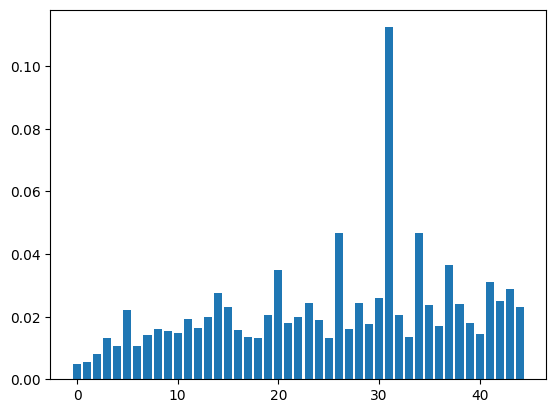

In [15]:
importance = xgb.feature_importances_
importancedf = pd.DataFrame(columns=['Feature', 'Score'])
# summarize feature importance
for i,v in enumerate(importance):
 #print('Feature: %0d, Score: %.5f' % (i,v))
    importancedf = importancedf.append({'Feature':i, 'Score':v}, ignore_index=True)
    importancedf = importancedf.astype({'Feature':'int'})
#print(importancedf)
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Choose top 11 features with highest importance

In [16]:
featurelist = list(X)

featuresdf = pd.DataFrame({'Feature': importancedf.iloc[:,0], 'Name': featurelist, 'Score':importancedf.iloc[:,1]})
featuresdf = featuresdf.sort_values(by=['Score'], ascending=False)
featuresdf.head(11)

,Feature,Name,Score
31,31,bpm,0.112471
34,34,gbpm,0.046772
26,26,pid,0.046708
37,37,dgbpm,0.036452
20,20,stl_per,0.034852
41,41,ast,0.030971
43,43,blk,0.028930
14,14,twoPA,0.027618
30,30,stops,0.025931
42,42,stl,0.025140


In [17]:
# Creates a target object for the pick and calls it y
y = ball_data.pick

# Creates X by using specific statistics
features = ['bpm', 'gbpm', 'pid', 'dgbpm', 'stl_per', 'ast', 'blk', 'twoPA', 'stops', 'stl', 'adrtg']
Xnew = ball_data[features]

# Split into validation and training data
train_Xnew, val_Xnew, train_y, val_y = train_test_split(Xnew, y, random_state=1)